In [1]:
import json
import glob
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_DIR = "../data/" 
MAX_SEQ_LEN = 198 
AUGMENTATION_FACTOR = 30

In [3]:
def extract_features(line_json):
    try:
        data = json.loads(line_json)
        feats = []
        # --- A. Thermal (192 Features) ---
        for pos in ['left', 'center', 'right']:
            if pos not in data['thermal']: return None
            pixels = np.array(data['thermal'][pos], dtype=np.float32)
            if len(pixels) != 64: return None
            feats.extend(pixels) 
        # --- B. Radar (6 Features) ---
        r1_e, r1_r, r1_s = 0, 0, 0
        r2_e, r2_r, r2_s = 0, 0, 0
        if 'mmWave' in data:
            r1 = data['mmWave'].get('R1', {})
            r2 = data['mmWave'].get('R2', {})
            r1_e, r1_r, r1_s = r1.get('energy', 0), r1.get('range', 0), r1.get('speed', 0)
            r2_e, r2_r, r2_s = r2.get('energy', 0), r2.get('range', 0), r2.get('speed', 0)
        elif 'radar' in data: 
            r1 = data['radar'].get('left', {})
            r2 = data['radar'].get('right', {})
            r1_e, r1_r, r1_s = r1.get('energy', 0), r1.get('range', 0), r1.get('speed', 0)
            r2_e, r2_r, r2_s = r2.get('energy', 0), r2.get('range', 0), r2.get('speed', 0)
        feats.append(r1_e); feats.append(float(r1_r)); feats.append(float(r1_s))
        feats.append(r2_e); feats.append(float(r2_r)); feats.append(float(r2_s))
        # --- C. Mic (2 Features) ---
        feats.append(data['mic'].get('left', 0.0))
        feats.append(data['mic'].get('right', 0.0))
        return np.array(feats, dtype=np.float32)
    except Exception as e: return None

In [4]:
print("--- 1. Loading Data ---")
files_0 = glob.glob(os.path.join(DATA_DIR, "data_label_0*.jsonl"))
files_1 = glob.glob(os.path.join(DATA_DIR, "data_label_1*.jsonl"))

raw_X = []
raw_y = []

def load_files(file_list, label):
    for f_path in file_list:
        with open(f_path, 'r') as f:
            seq = []
            for line in f:
                feat = extract_features(line)
                if feat is not None: seq.append(feat)
            if len(seq) > 0:
                raw_X.append(np.array(seq))
                raw_y.append(label)

load_files(files_0, 0.0)
load_files(files_1, 1.0)

if len(raw_X) == 0:
    print("❌ ERROR: No data found.")
    exit()

X_padded = pad_sequences(raw_X, maxlen=MAX_SEQ_LEN, dtype='float32', padding='pre', truncating='post')
y_raw = np.array(raw_y)

print(f"✅ Loaded {len(raw_X)} sequences.")

--- 1. Loading Data ---
✅ Loaded 58 sequences.


In [5]:
print(f"--- 2. Augmenting Data ---")
aug_X_list, aug_y_list = [], []
for i, seq in enumerate(X_padded):
    label = y_raw[i]
    aug_X_list.append(seq); aug_y_list.append(label)
    for _ in range(AUGMENTATION_FACTOR):
        new_seq = seq.copy()
        noise = np.random.normal(0, 0.2, new_seq.shape) # Stronger noise
        temp_shift = np.random.uniform(-5.0, 5.0) 
        new_seq[:, :192] += temp_shift
        new_seq += noise
        aug_X_list.append(new_seq); aug_y_list.append(label)

X_final = np.array(aug_X_list, dtype=np.float32)
y_final = np.array(aug_y_list, dtype=np.float32)

print(f"✅ Augmented dataset size: {X_final.shape[0]} sequences.")
print(f"Original dataset size: {len(raw_X)} sequences.")
print(f"Each sequence length: {X_final.shape[1]} timesteps, Feature dimension: {X_final.shape[2]}.")
print(f"Increased dataset size by a factor of {X_final.shape[0] / len(raw_X):.2f}x.")

--- 2. Augmenting Data ---
✅ Augmented dataset size: 1798 sequences.
Original dataset size: 58 sequences.
Each sequence length: 198 timesteps, Feature dimension: 200.
Increased dataset size by a factor of 31.00x.


In [6]:
print("--- 3. Calculating Stats ---")
X_flat = X_final.reshape(-1, X_final.shape[2])
mean_vals = np.mean(X_flat, axis=0)
std_vals = np.std(X_flat, axis=0)
std_vals[std_vals == 0] = 1.0 
X_norm = (X_final - mean_vals) / std_vals

with open("normalization_values.h", "w") as f:
    f.write("#ifndef NORMALIZATION_VALUES_H\n#define NORMALIZATION_VALUES_H\n\n")
    f.write("const float MEAN_VALS[] = {\n")
    for val in mean_vals: f.write(f"{val:.4f}, ")
    f.write("};\nconst float STD_VALS[] = {\n")
    for val in std_vals: f.write(f"{val:.4f}, ")
    f.write("};\n#endif\n")
    
print("Normalization values saved to normalization_values.h")
print(f"Mean and Std Dev calculated for {len(mean_vals)} features.")

--- 3. Calculating Stats ---
Normalization values saved to normalization_values.h
Mean and Std Dev calculated for 200 features.


In [7]:
print("--- Training Speed Demon Model ---")
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_final, test_size=0.2, random_state=69)

model = Sequential([
    Input(shape=(MAX_SEQ_LEN, 200)),

    # LAYER 1: Feature Compressor
    # Reduce 200 sensors to 12 key features immediately.
    # Cost: Low.
    Conv1D(12, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # LAYER 2: Strided Time Scan
    # Strides=3 means we skip 2 steps for every 1 we process.
    # This cuts the sequence length from 198 -> 66 instantly. 
    # Speedup: 300%
    Conv1D(16, kernel_size=3, strides=3, padding='valid', activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # LAYER 3: Second Stride
    # 66 -> 33 steps.
    Conv1D(24, kernel_size=3, strides=2, padding='valid', activation='relu'),

    # Flatten the remaining small matrix (33 * 24)
    Flatten(),
    Dropout(0.4),
    
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

--- Training Speed Demon Model ---


In [8]:
print("--- 4. Training Robust Model ---")

# Calculate class weights dynamically based on training data
# This is better than hardcoding as it adapts to the specific split
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights_vals))
print(f"Computed Class Weights: {class_weights}")

# Compile with AUC which is more informative for imbalanced datasets
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras", monitor='val_loss', save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]


history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=8,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks
)

--- 4. Training Robust Model ---
Computed Class Weights: {np.float32(0.0): np.float64(1.13946117274168), np.float32(1.0): np.float64(0.8909541511771994)}
Epoch 1/100
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4874 - auc: 0.4864 - loss: 0.7579
Epoch 1: val_loss improved from None to 0.68181, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5160 - auc: 0.5215 - loss: 0.7137 - val_accuracy: 0.5583 - val_auc: 0.5607 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 2/100
145/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5665 - auc: 0.5167 - loss: 0.6952
Epoch 2: val_loss improved from 0.68181 to 0.66376, saving model to best_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5542 - auc: 0.5573 - loss: 0.6838 - val_accuracy: 0.5611 - val_auc: 0.6172 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 3/100
170/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5589 - auc: 0.5844 - loss: 0.6766
Epoch 3: val_loss did not impr

In [9]:
# Get overall accuracy (loss, accuracy, auc)
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%  |  AUC: {auc:.4f}")
print(f"Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.4572e-05  
Test Accuracy: 100.00%  |  AUC: 1.0000
Loss: 0.0001


In [10]:
print("\n--- DIAGNOSTICS ---")
y_pred_prob = model.predict(X_test)
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    y_bin = (y_pred_prob > thresh).astype(int)
    score = f1_score(y_test, y_bin)
    if score > best_f1:
        best_f1 = score; best_thresh = thresh

print(f"✅ Best Threshold: {best_thresh:.2f} (F1: {best_f1:.2f})")
y_pred_binary = (y_pred_prob > best_thresh).astype(int)
print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary, target_names=['Not Animal', 'Animal']))


--- DIAGNOSTICS ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ Best Threshold: 0.10 (F1: 1.00)
[[175   0]
 [  0 185]]
              precision    recall  f1-score   support

  Not Animal       1.00      1.00      1.00       175
      Animal       1.00      1.00      1.00       185

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



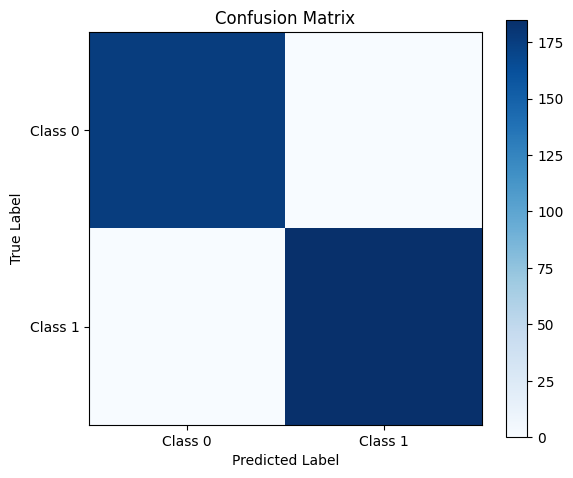

In [11]:
# compute confusion matrix (ensure 1D arrays)
cm = confusion_matrix(y_test, y_pred_binary.ravel())

# plot confusion matrix beautifully
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

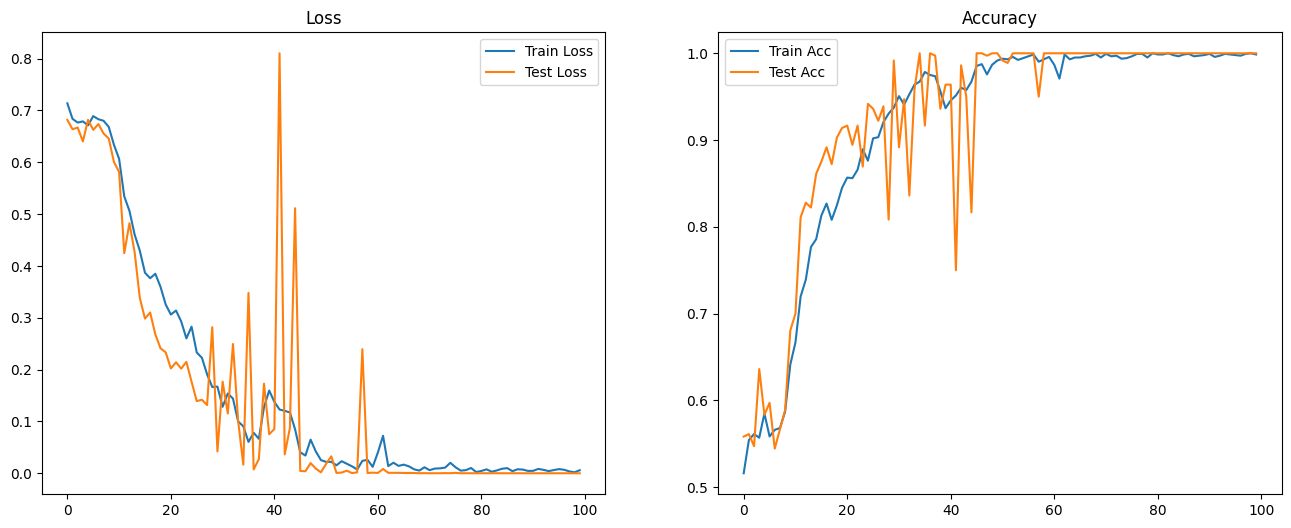

In [12]:
# Plot Loss Curve
try:
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Test Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Could not plot: {e}")

In [13]:
print("--- 5. Exporting to TFLite Int8 ---")

# Generator must produce shape (1, MAX_SEQ_LEN, feature_dim) -> (1, 198, 56)
def representative_dataset_gen():
    # Use X_train shape to get correct feature dimension and avoid wrong len() usage
    n_samples = min(100, X_train.shape[0])
    for i in range(n_samples):
        # slice keeps shape (1, MAX_SEQ_LEN, feature_dim)
        sample = X_train[i:i+1].astype(np.float32)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# Enforce Full Integer Quantization (ESP32-S3 vector instruction compatible)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
open("model_int8.tflite", "wb").write(tflite_model)
print(f"Wrote model_int8.tflite, size: {len(tflite_model)} bytes")

--- 5. Exporting to TFLite Int8 ---
INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpgrvr21vm/assets


INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpgrvr21vm/assets


Saved artifact at '/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpgrvr21vm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 198, 200), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5689342464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689341408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689343696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689508080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689509664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689509488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689513888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689511952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689511600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689513712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5689512832: TensorSpec(

/Users/wanghley/miniconda3/envs/agronaults/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Wrote model_int8.tflite, size: 26936 bytes


W0000 00:00:1763933917.234017 1264911 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1763933917.234027 1264911 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-23 16:38:37.234209: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpgrvr21vm
2025-11-23 16:38:37.234785: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-23 16:38:37.234791: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpgrvr21vm
I0000 00:00:1763933917.239830 1264911 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-23 16:38:37.240739: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-23 16:38:37.273026: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

In [14]:
# Check ops
interpreter = tf.lite.Interpreter(model_path='model_int8.tflite')
interpreter.allocate_tensors()
ops = interpreter._get_ops_details() 
print("Ops in model:", [op['op_name'] for op in ops])

# Export to C Header
data = open('model_int8.tflite','rb').read()
hex_array = ", ".join([f"0x{b:02x}" for b in data])
with open('model.h','w') as f:
    f.write("#ifndef MODEL_H\n#define MODEL_H\n#include <Arduino.h>\n\n")
    f.write(f"alignas(16) const unsigned char model_tflite[] = {{ {hex_array} }};\n")
    f.write(f"const unsigned int model_tflite_len = {len(data)};\n\n#endif\n")
print("✅ Wrote optimized model.h")

Ops in model: ['EXPAND_DIMS', 'CONV_2D', 'MUL', 'ADD', 'RESHAPE', 'EXPAND_DIMS', 'CONV_2D', 'MUL', 'ADD', 'RESHAPE', 'EXPAND_DIMS', 'CONV_2D', 'RESHAPE', 'SHAPE', 'STRIDED_SLICE', 'PACK', 'RESHAPE', 'FULLY_CONNECTED', 'FULLY_CONNECTED', 'LOGISTIC', 'DELEGATE', 'DELEGATE', 'DELEGATE', 'DELEGATE']
✅ Wrote optimized model.h


/Users/wanghley/miniconda3/envs/agronaults/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
